In [1]:
# !wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import nltk

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from pycaret.classification import *
import optuna
import lightgbm as lgb

# Project-specific imports
from scripts.utils import load_data
from scripts.preprocessing import preprocess_data
from scripts.modelling import tfidf_vectorizer, objective_apc, calculate_metrics

warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to /Users/busra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing

In [2]:
sms_spam_df = load_data('datasets/sms_spam_train.csv')

Dataset loaded from: datasets/sms_spam_train.csv

First 10 rows of the dataset:


,Message,Label
0,Whats upp ac enisteee: -) senin memlekette buldum..,ham
1,"Kampanya, VakifBank Worldcardla 31 Mayisa kadar World uyesi gida,giyim,restoran,beyaz esyada ilk 100 TL sonrasi her 100 TL alisverise 10 TL, maksimum 50 TL Worldpuan. Katilmak icin MAYIS yaz, kartin son 6 hanesini 6635e gonder.",spam
2,I wont. So wat's wit the guys,ham
3,Bu arada son dakika evi düşürdük,ham
4,No that just means you have a fat head,ham
5,The battery is for mr adewale my uncle. Aka Egbon,ham
6,it to 80488. Your 500 free text messages are valid until 31 December 2005.,spam
7,How come guoyang go n tell her? Then u told her?,ham
8,"I can. But it will tell quite long, cos i haven't finish my film yet...",ham
9,Playstation tercih ederim :),ham



Dataset Info:


,Data Type
Message,object
Label,object



Missing values in each column: 


Message    0
Label      0
dtype: int64


Number of duplicate rows: 332

Label distribution:


Label
ham     0.6621
spam    0.3379
Name: proportion, dtype: float64

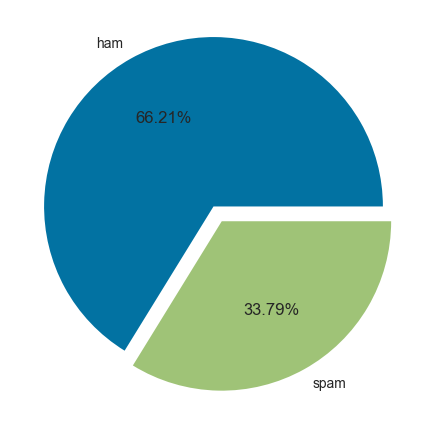

In [3]:
plt.pie(sms_spam_df.Label.value_counts(), labels=['ham', 'spam'], autopct='%0.2f%%', explode=[0.1,0])
plt.show()

In [4]:
sms_spam_df = preprocess_data(sms_spam_df)

Language
en         4721
tr         4005
id          913
unknown      26
Name: count, dtype: int64

In [5]:
sms_spam_df.to_csv('datasets/sms_spam_df.csv')

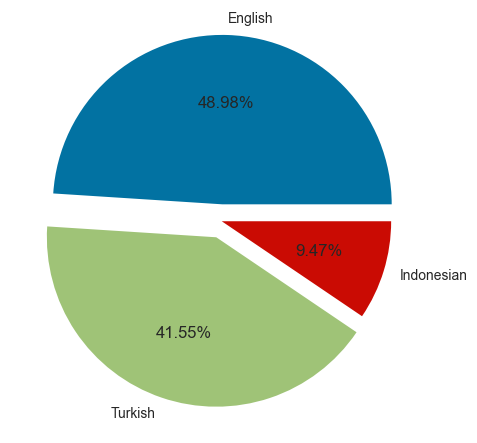

In [6]:
plt.pie(sms_spam_df.Language.value_counts(), labels =['English' , 'Turkish', 'Indonesian'], autopct='%0.2f%%', explode=[0.1, 0.1, 0])
plt.show()

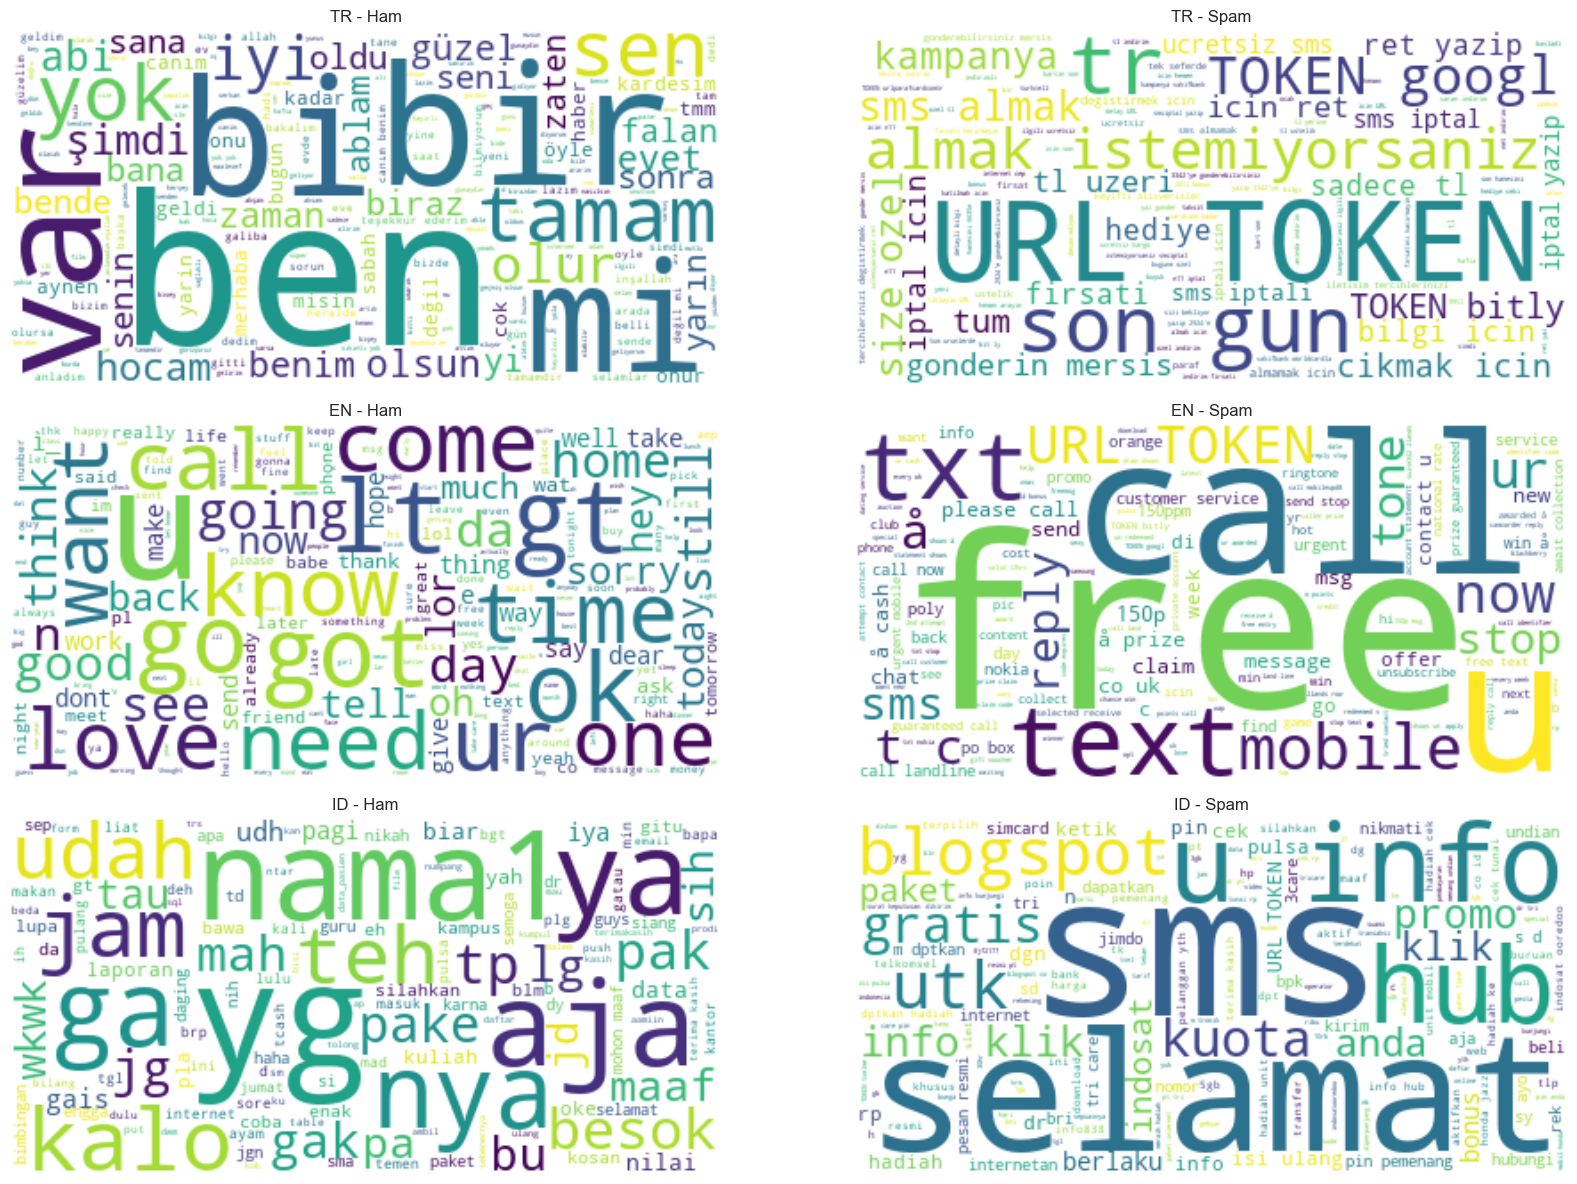

In [7]:
# Get unique (Language, Label) pairs
language_label_pairs = sms_spam_df[['Language', 'Label']].drop_duplicates().values

# Set figure size
plt.figure(figsize=(18, 12)) 

# Generate Word Cloud for each (Language, Label) pair
for i, (lang, label) in enumerate(language_label_pairs, 1):
    if label == 1:
        label_name = "spam"
    else:
        label_name = "ham"
    subset = sms_spam_df[(sms_spam_df['Language'] == lang) & (sms_spam_df['Label'] == label)]
    
    text = " ".join(subset['Message'])
    wordcloud = WordCloud(background_color="white").generate(text)

    plt.subplot(3, 2, i) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"{lang.upper()} - {label_name.capitalize()}")

plt.tight_layout()
plt.show()

# Auto ML

In [8]:
# Split dataset 
X, y = sms_spam_df['Message'], sms_spam_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)

# TDIDF vectorizer
X_train_ml, y_train, vectorizer = tfidf_vectorizer(X_train, y_train)
X_test_ml = vectorizer.transform(X_test)

In [9]:
# Convert sparse matrix to df
X_train_df = pd.DataFrame(X_train_ml.toarray())  

# Concatenate feature matrix with labels
train_df = pd.concat([X_train_df, y_train.reset_index(drop=True)], axis=1)


In [27]:
# PyCaret setup 
clf_setup = setup(
    data=train_df,   # Drop 'id' for training
    target='Label',
    session_id=123,    
    fold=5  # Use 5 folds during cross-validation
)
# Add AUPRC
add_metric('apc', 'APC', average_precision_score, target = 'pred_proba')

exclude_models = ['dummy']
best_model = compare_models(exclude=exclude_models, sort='APC')

,Description,Value
0,Session id,123
1,Target,Label
2,Target type,Binary
3,Original data shape,"(7711, 5001)"
4,Transformed data shape,"(7711, 5001)"
5,Transformed train set shape,"(5397, 5001)"
6,Transformed test set shape,"(2314, 5001)"
7,Numeric features,5000
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
rf,Random Forest Classifier,0.9733,0.9943,0.9403,0.9808,0.9600,0.9400,0.9406,0.9921,1.5580
lr,Logistic Regression,0.9600,0.9946,0.8947,0.9868,0.9384,0.9089,0.9114,0.9915,1.9160
et,Extra Trees Classifier,0.9772,0.9944,0.9577,0.9752,0.9663,0.9491,0.9492,0.9911,2.9280
lightgbm,Light Gradient Boosting Machine,0.9637,0.9888,0.9273,0.9653,0.9457,0.9184,0.9190,0.9844,1.1980
xgboost,Extreme Gradient Boosting,0.9603,0.9887,0.9055,0.9768,0.9396,0.9102,0.9118,0.9839,3.3940
gbc,Gradient Boosting Classifier,0.9313,0.9793,0.8138,0.9818,0.8897,0.8404,0.8484,0.9699,5.3400
ada,Ada Boost Classifier,0.9496,0.9690,0.8930,0.9565,0.9236,0.8861,0.8873,0.9567,2.9180
dt,Decision Tree Classifier,0.9529,0.9494,0.9218,0.9393,0.9304,0.8948,0.8950,0.8993,1.7740
nb,Naive Bayes,0.9561,0.9570,0.9598,0.9158,0.9371,0.9034,0.9042,0.8926,1.1460
knn,K Neighbors Classifier,0.7173,0.7491,0.1716,1.0000,0.2927,0.2143,0.3463,0.6674,2.3180


In [35]:
train_df = pd.concat([X_train, y_train], axis=1)

In [37]:
# PyCaret setup with automatic text processing
clf_setup = setup(
    data=train_df, 
    target="Label", 
    text_features=["Message"],  # Enables automatic TF-IDF
    session_id=123, 
    fold=5
)
# Add AUPRC
add_metric('apc', 'APC', average_precision_score, target = 'pred_proba')

exclude_models = ['dummy']
best_model = compare_models(exclude=exclude_models, sort='APC')

,Description,Value
0,Session id,123
1,Target,Label
2,Target type,Binary
3,Original data shape,"(7711, 2)"
4,Transformed data shape,"(7711, 16865)"
5,Transformed train set shape,"(5397, 16865)"
6,Transformed test set shape,"(2314, 16865)"
7,Text features,1
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
et,Extra Trees Classifier,0.9767,0.9952,0.9462,0.9848,0.9651,0.9476,0.9480,0.9929,3.0460
rf,Random Forest Classifier,0.9720,0.9946,0.9310,0.9863,0.9578,0.9369,0.9379,0.9922,5.6560
lr,Logistic Regression,0.9611,0.9944,0.8990,0.9857,0.9403,0.9115,0.9137,0.9913,7.4560
xgboost,Extreme Gradient Boosting,0.9616,0.9902,0.9055,0.9810,0.9414,0.9130,0.9149,0.9852,192.5340
lightgbm,Light Gradient Boosting Machine,0.9622,0.9888,0.9186,0.9693,0.9431,0.9148,0.9158,0.9843,1.5880
gbc,Gradient Boosting Classifier,0.9301,0.9797,0.8100,0.9824,0.8876,0.8377,0.8461,0.9699,16.6240
ada,Ada Boost Classifier,0.9492,0.9672,0.8947,0.9537,0.9232,0.8854,0.8864,0.9551,33.1780
knn,K Neighbors Classifier,0.9283,0.9681,0.8512,0.9352,0.8899,0.8370,0.8403,0.9226,5.9840
dt,Decision Tree Classifier,0.9498,0.9389,0.9045,0.9463,0.9248,0.8871,0.8878,0.8885,1.9440
nb,Naive Bayes,0.9533,0.9555,0.9625,0.9065,0.9336,0.8977,0.8987,0.8854,2.1260


In [30]:
# Train an RF model 
clf_setup = setup(
    data=train_df,  
    target='Label',
    session_id=123,    
    fold=5  # Use 5 folds during cross-validation
)

add_metric('apc', 'APC', average_precision_score, target = 'pred_proba')

rf_model = create_model('rf')
evaluate_model(rf_model)

,Description,Value
0,Session id,123
1,Target,Label
2,Target type,Binary
3,Original data shape,"(7711, 5001)"
4,Transformed data shape,"(7711, 5001)"
5,Transformed train set shape,"(5397, 5001)"
6,Transformed test set shape,"(2314, 5001)"
7,Numeric features,5000
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9750,0.9963,0.9458,0.9803,0.9628,0.9440,0.9443,0.9943
1,0.9713,0.9870,0.9431,0.9721,0.9574,0.9357,0.9360,0.9851
2,0.9676,0.9965,0.9185,0.9854,0.9508,0.9266,0.9279,0.9937
3,0.9741,0.9946,0.9348,0.9885,0.9609,0.9415,0.9423,0.9928
4,0.9787,0.9971,0.9592,0.9778,0.9684,0.9524,0.9525,0.9945
Mean,0.9733,0.9943,0.9403,0.9808,0.9600,0.9400,0.9406,0.9921
Std,0.0037,0.0037,0.0134,0.0058,0.0059,0.0086,0.0082,0.0035


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [22]:
#Tune Hyperparameters
tuned_rf_model = tune_model(rf_model, optimize='APC') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9176,0.9898,0.7615,0.9965,0.8633,0.8058,0.8207,0.9869
1,0.9130,0.9867,0.7507,0.9928,0.8549,0.7945,0.8103,0.9811
2,0.9027,0.9878,0.7174,0.9962,0.8341,0.7678,0.7885,0.9822
3,0.9203,0.9780,0.7690,0.9965,0.8681,0.8123,0.8263,0.9771
4,0.9277,0.9937,0.7962,0.9899,0.8825,0.8312,0.8415,0.9881
Mean,0.9163,0.9872,0.7590,0.9944,0.8606,0.8023,0.8175,0.9831
Std,0.0083,0.0052,0.0257,0.0026,0.0160,0.0210,0.0176,0.0040


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


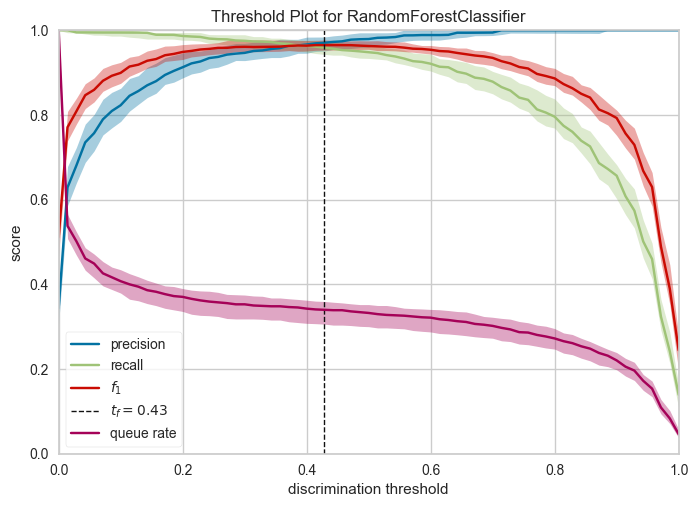

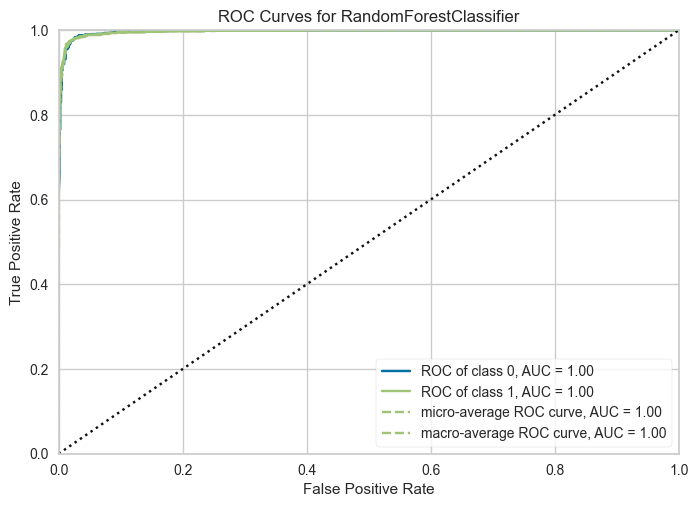

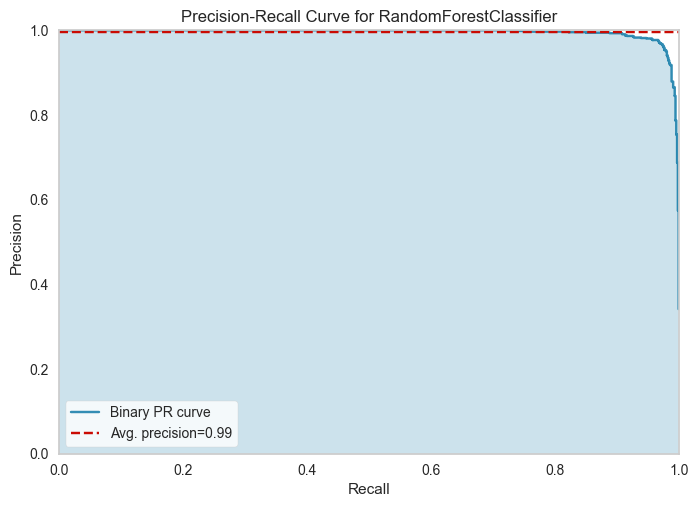

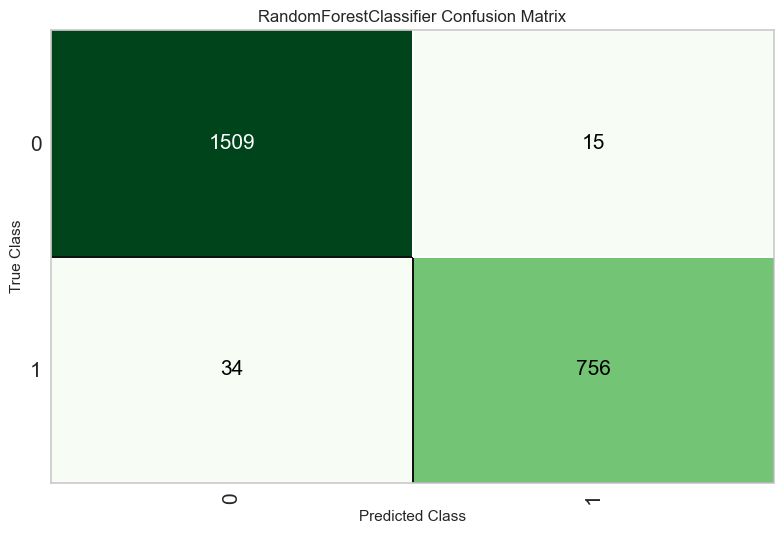

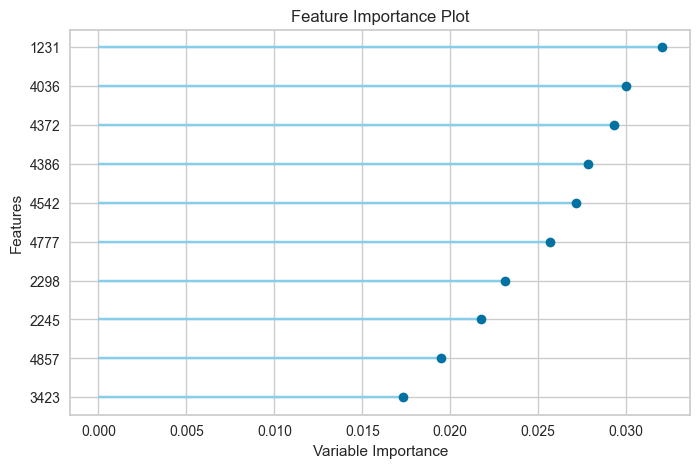

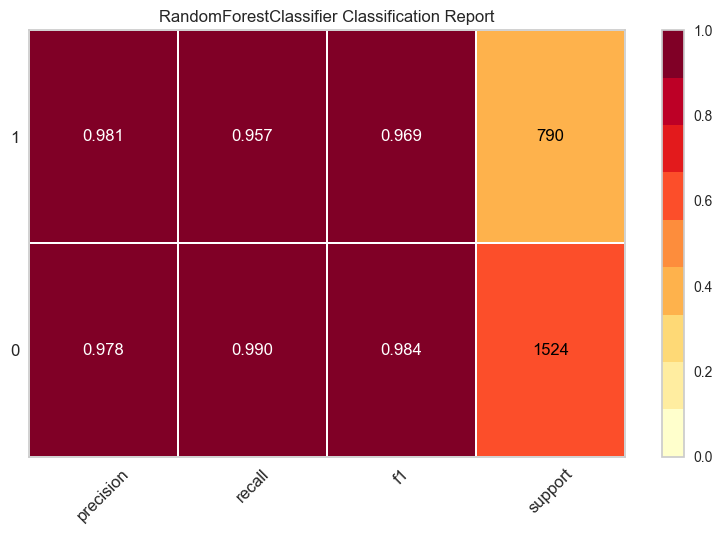

In [23]:

# Discrimination Threshold
plot_model(tuned_rf_model, plot='threshold')

# Area Under the Curve
plot_model(tuned_rf_model, plot='auc')

# Precision-Recall Curve
plot_model(tuned_rf_model, plot='pr')

# Confusion Matrix
plot_model(tuned_rf_model, plot='confusion_matrix')

# Feature Importance
plot_model(tuned_rf_model, plot='feature')

# Classification Report
plot_model(tuned_rf_model, plot='class_report')


In [28]:
predict_model(tuned_rf_model, probability_threshold=0.4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Random Forest Classifier,0.9793,0.9970,0.9696,0.9696,0.9696,0.9539,0.9539,0.9948


,0,1,2,3,4,5,6,7,8,9,...,4993,4994,4995,4996,4997,4998,4999,Label,prediction_label,prediction_score
3328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0000
6634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7996
992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9800
4230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0000
745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0000
1365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9996
3162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9900
3701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0000


In [29]:
X_test_df = pd.DataFrame(X_test_ml.toarray())  
test_df = pd.concat([X_test_df, y_test.reset_index(drop=True)], axis=1)

# Predict on test set seperated before
predict_model(tuned_rf_model, data=test_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Random Forest Classifier,0.9844,0.9975,0.9726,0.9816,0.9771,0.9653,0.9653,0.9960


,0,1,2,3,4,5,6,7,8,9,...,4993,4994,4995,4996,4997,4998,4999,Label,prediction_label,prediction_score
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0000
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9801
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9955
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9600
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9688
1924,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.8000
1925,0.0,0.273528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9500
1926,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0000


# Custom Training

In [10]:
sms_spam_df = pd.read_csv('datasets/sms_spam_df.csv', index_col=0)
X, y = sms_spam_df['Message'], sms_spam_df['Label']

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)

# Split X_train into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=42, test_size=0.2)

# Prepare data for ML
X_train_ml, y_train, vectorizer = tfidf_vectorizer(X_train, y_train)
X_val_ml = vectorizer.transform(X_val)
X_test_ml = vectorizer.transform(X_test)

In [11]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_apc(trial, X_train_ml, y_train, X_val_ml, y_val), n_trials=50)

[I 2025-02-04 12:15:49,557] A new study created in memory with name: no-name-aa68d07a-7072-4821-b2fc-355a2fd78b42


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=4.53987930625193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.53987930625193
[LightGBM] [Warning] lambda_l2 is set=8.44026126328092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.44026126328092
[LightGBM] [Warning] feature_fraction is set=0.9594001689130057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9594001689130057
[LightGBM] [Warning] bagging_fraction is set=0.8393105519712445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8393105519712445


[I 2025-02-04 12:15:50,060] Trial 0 finished with value: 0.979901660946597 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 168, 'learning_rate': 0.07806907731415162, 'feature_fraction': 0.9594001689130057, 'max_depth': 10, 'lambda_l1': 4.53987930625193, 'lambda_l2': 8.44026126328092, 'min_child_weight': 5.494980660516899, 'n_estimators': 171, 'bagging_fraction': 0.8393105519712445, 'bagging_freq': 2}. Best is trial 0 with value: 0.979901660946597.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=2.260113189134584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.260113189134584
[LightGBM] [Warning] lambda_l2 is set=7.244537215794629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.244537215794629
[LightGBM] [Warning] feature_fraction is set=0.7031308907672759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7031308907672759
[LightGBM] [Warning] bagging_fraction is set=0.9533997129663887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533997129663887


[I 2025-02-04 12:15:50,745] Trial 1 finished with value: 0.9616627554868649 and parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'learning_rate': 0.13082686644274233, 'feature_fraction': 0.7031308907672759, 'max_depth': 3, 'lambda_l1': 2.260113189134584, 'lambda_l2': 7.244537215794629, 'min_child_weight': 2.4051009062699533, 'n_estimators': 276, 'bagging_fraction': 0.9533997129663887, 'bagging_freq': 7}. Best is trial 0 with value: 0.979901660946597.


[LightGBM] [Warning] lambda_l1 is set=8.390306579852249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.390306579852249
[LightGBM] [Warning] lambda_l2 is set=7.149206596188202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.149206596188202
[LightGBM] [Warning] feature_fraction is set=0.8806467260528651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8806467260528651


[I 2025-02-04 12:15:51,251] Trial 2 finished with value: 0.9807550008919865 and parameters: {'boosting_type': 'goss', 'num_leaves': 223, 'learning_rate': 0.11511978598668055, 'feature_fraction': 0.8806467260528651, 'max_depth': 14, 'lambda_l1': 8.390306579852249, 'lambda_l2': 7.149206596188202, 'min_child_weight': 5.31459786160675, 'n_estimators': 220}. Best is trial 2 with value: 0.9807550008919865.
[I 2025-02-04 12:15:51,370] Trial 3 finished with value: 0.9338974113500847 and parameters: {'boosting_type': 'goss', 'num_leaves': 175, 'learning_rate': 0.051470613178251426, 'feature_fraction': 0.6462481990934874, 'max_depth': 8, 'lambda_l1': 6.669177444979518, 'lambda_l2': 7.221468199413382, 'min_child_weight': 9.742263812850833, 'n_estimators': 251}. Best is trial 2 with value: 0.9807550008919865.


[LightGBM] [Warning] lambda_l1 is set=6.669177444979518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.669177444979518
[LightGBM] [Warning] lambda_l2 is set=7.221468199413382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.221468199413382
[LightGBM] [Warning] feature_fraction is set=0.6462481990934874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6462481990934874
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=5.685646292481378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.685646292481378
[LightGBM] [Warning] lambda_l2 is set=1.8329553738414728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8329553738414728
[LightGBM] [Warning] feature_fraction is set=0.7997638291543915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7997638291543915
[LightGBM] [Warning] bagging_fraction is set=0.848559242

[I 2025-02-04 12:15:52,091] Trial 4 finished with value: 0.9746084598251089 and parameters: {'boosting_type': 'dart', 'num_leaves': 214, 'learning_rate': 0.17110219147037475, 'feature_fraction': 0.7997638291543915, 'max_depth': 6, 'lambda_l1': 5.685646292481378, 'lambda_l2': 1.8329553738414728, 'min_child_weight': 2.39889596090053, 'n_estimators': 216, 'bagging_fraction': 0.8485592423939576, 'bagging_freq': 3}. Best is trial 2 with value: 0.9807550008919865.
[I 2025-02-04 12:15:52,151] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2025-02-04 12:15:52,222] Trial 6 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=4.676620757401548, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.676620757401548
[LightGBM] [Warning] lambda_l2 is set=7.08700760853511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.08700760853511
[LightGBM] [Warning] feature_fraction is set=0.6319249006554991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6319249006554991
[LightGBM] [Warning] bagging_fraction is set=0.6607578469092429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6607578469092429


[I 2025-02-04 12:15:52,575] Trial 7 pruned. Trial was pruned at iteration 148.
[I 2025-02-04 12:15:52,830] Trial 8 finished with value: 0.9778175139785026 and parameters: {'boosting_type': 'goss', 'num_leaves': 127, 'learning_rate': 0.11325650993598806, 'feature_fraction': 0.8565183732634829, 'max_depth': 10, 'lambda_l1': 9.55991760194301, 'lambda_l2': 4.398047021726136, 'min_child_weight': 5.76270022709621, 'n_estimators': 101}. Best is trial 2 with value: 0.9807550008919865.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l1 is set=1.616339516135864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.616339516135864
[LightGBM] [Warning] lambda_l2 is set=2.219040083902355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.219040083902355
[LightGBM] [Warning] feature_fraction is set=0.713373449002765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.713373449002765
[LightGBM] [Warning] bagging_fraction is set=0.767658512768916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.767658512768916


[I 2025-02-04 12:15:53,566] Trial 9 finished with value: 0.9829519217729471 and parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'learning_rate': 0.2681855864906198, 'feature_fraction': 0.713373449002765, 'max_depth': 9, 'lambda_l1': 1.616339516135864, 'lambda_l2': 2.219040083902355, 'min_child_weight': 0.7461337399050098, 'n_estimators': 193, 'bagging_fraction': 0.767658512768916, 'bagging_freq': 8}. Best is trial 9 with value: 0.9829519217729471.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=1.581817467372037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.581817467372037
[LightGBM] [Warning] lambda_l2 is set=0.25781562139572856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25781562139572856
[LightGBM] [Warning] feature_fraction is set=0.7597824125136645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7597824125136645
[LightGBM] [Warning] bagging_fraction is set=0.6865159846524057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6865159846524057


[I 2025-02-04 12:15:54,244] Trial 10 finished with value: 0.984814183610243 and parameters: {'boosting_type': 'dart', 'num_leaves': 273, 'learning_rate': 0.2981596203859719, 'feature_fraction': 0.7597824125136645, 'max_depth': 15, 'lambda_l1': 1.581817467372037, 'lambda_l2': 0.25781562139572856, 'min_child_weight': 0.012973096772153192, 'n_estimators': 130, 'bagging_fraction': 0.6865159846524057, 'bagging_freq': 10}. Best is trial 10 with value: 0.984814183610243.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=0.46355449497646184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46355449497646184
[LightGBM] [Warning] lambda_l2 is set=0.03522695014373142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03522695014373142
[LightGBM] [Warning] feature_fraction is set=0.7482290320230638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7482290320230638
[LightGBM] [Warning] bagging_fraction is set=0.68550117772344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.68550117772344


[I 2025-02-04 12:15:54,779] Trial 11 finished with value: 0.9863889007552777 and parameters: {'boosting_type': 'dart', 'num_leaves': 269, 'learning_rate': 0.2972772163850801, 'feature_fraction': 0.7482290320230638, 'max_depth': 15, 'lambda_l1': 0.46355449497646184, 'lambda_l2': 0.03522695014373142, 'min_child_weight': 0.25045588356230575, 'n_estimators': 122, 'bagging_fraction': 0.68550117772344, 'bagging_freq': 10}. Best is trial 11 with value: 0.9863889007552777.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=0.13453128828541994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13453128828541994
[LightGBM] [Warning] lambda_l2 is set=0.45964636537866144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.45964636537866144
[LightGBM] [Warning] feature_fraction is set=0.777841917498427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.777841917498427
[LightGBM] [Warning] bagging_fraction is set=0.6182009164692555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6182009164692555


[I 2025-02-04 12:15:55,284] Trial 12 finished with value: 0.9865058020534101 and parameters: {'boosting_type': 'dart', 'num_leaves': 299, 'learning_rate': 0.24279445468411154, 'feature_fraction': 0.777841917498427, 'max_depth': 15, 'lambda_l1': 0.13453128828541994, 'lambda_l2': 0.45964636537866144, 'min_child_weight': 0.17571645987437384, 'n_estimators': 117, 'bagging_fraction': 0.6182009164692555, 'bagging_freq': 10}. Best is trial 12 with value: 0.9865058020534101.
[I 2025-02-04 12:15:55,403] Trial 13 pruned. Trial was pruned at iteration 1.
[I 2025-02-04 12:15:55,469] Trial 14 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=0.0684953210444937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0684953210444937
[LightGBM] [Warning] lambda_l2 is set=0.12497761033167887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12497761033167887
[LightGBM] [Warning] feature_fraction is set=0.8314836119754099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8314836119754099
[LightGBM] [Warning] bagging_fraction is set=0.6231334824469646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6231334824469646


[I 2025-02-04 12:15:55,606] Trial 15 pruned. Trial was pruned at iteration 11.
[I 2025-02-04 12:15:55,686] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2025-02-04 12:15:56,005] Trial 17 pruned. Trial was pruned at iteration 73.
[I 2025-02-04 12:15:56,109] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2025-02-04 12:15:56,185] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2025-02-04 12:15:56,272] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2025-02-04 12:15:56,851] Trial 21 finished with value: 0.9852465805607549 and parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'learning_rate': 0.29241581398859273, 'feature_fraction': 0.7575068293947798, 'max_depth': 15, 'lambda_l1': 1.632577233191637, 'lambda_l2': 0.03418694007779699, 'min_child_weight': 0.15080436327654204, 'n_estimators': 115, 'bagging_fraction': 0.6924313892212839, 'bagging_freq': 10}. Best is trial 12 with value: 0.9865058020534101.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=1.1918311148413832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1918311148413832
[LightGBM] [Warning] lambda_l2 is set=1.157785156268167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.157785156268167
[LightGBM] [Warning] feature_fraction is set=0.7565352120558683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7565352120558683
[LightGBM] [Warning] bagging_fraction is set=0.7171076538598052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7171076538598052


[I 2025-02-04 12:15:57,363] Trial 22 finished with value: 0.9832319173349182 and parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'learning_rate': 0.2911825287318484, 'feature_fraction': 0.7565352120558683, 'max_depth': 14, 'lambda_l1': 1.1918311148413832, 'lambda_l2': 1.157785156268167, 'min_child_weight': 1.526940234755958, 'n_estimators': 106, 'bagging_fraction': 0.7171076538598052, 'bagging_freq': 9}. Best is trial 12 with value: 0.9865058020534101.
[I 2025-02-04 12:15:57,466] Trial 23 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.1022505531682087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1022505531682087
[LightGBM] [Warning] lambda_l2 is set=0.034716962648298474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034716962648298474
[LightGBM] [Warning] feature_fraction is set=0.8321011302228765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8321011302228765
[LightGBM] [Warning] bagging_fraction is set=0.6652453201993775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6652453201993775


[I 2025-02-04 12:15:58,247] Trial 24 finished with value: 0.9842228679637672 and parameters: {'boosting_type': 'dart', 'num_leaves': 193, 'learning_rate': 0.21517420479151178, 'feature_fraction': 0.7386754294877116, 'max_depth': 14, 'lambda_l1': 0.5901819727690985, 'lambda_l2': 1.5966306264031283, 'min_child_weight': 0.9801194889675189, 'n_estimators': 152, 'bagging_fraction': 0.7952264433617737, 'bagging_freq': 10}. Best is trial 12 with value: 0.9865058020534101.
[I 2025-02-04 12:15:58,363] Trial 25 pruned. Trial was pruned at iteration 1.
[I 2025-02-04 12:15:58,435] Trial 26 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=0.12990520673856648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12990520673856648
[LightGBM] [Warning] lambda_l2 is set=0.7215878981897461, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7215878981897461
[LightGBM] [Warning] feature_fraction is set=0.787218411045745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.787218411045745
[LightGBM] [Warning] bagging_fraction is set=0.6331702907176976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6331702907176976


[I 2025-02-04 12:15:58,566] Trial 27 pruned. Trial was pruned at iteration 4.
[I 2025-02-04 12:15:58,647] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2025-02-04 12:15:58,703] Trial 29 pruned. Trial was pruned at iteration 2.
[I 2025-02-04 12:15:58,787] Trial 30 pruned. Trial was pruned at iteration 0.
[I 2025-02-04 12:15:59,507] Trial 31 finished with value: 0.9845914463706086 and parameters: {'boosting_type': 'dart', 'num_leaves': 274, 'learning_rate': 0.24293456087246348, 'feature_fraction': 0.755372831967785, 'max_depth': 15, 'lambda_l1': 1.517057141510583, 'lambda_l2': 0.04053648833734236, 'min_child_weight': 0.0884109612572811, 'n_estimators': 137, 'bagging_fraction': 0.6804681468921017, 'bagging_freq': 10}. Best is trial 12 with value: 0.9865058020534101.
[I 2025-02-04 12:15:59,603] Trial 32 pruned. Trial was pruned at iteration 0.
[I 2025-02-04 12:15:59,659] Trial 33 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.0574487268751014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0574487268751014
[LightGBM] [Warning] lambda_l2 is set=0.8002218709760366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8002218709760366
[LightGBM] [Warning] feature_fraction is set=0.7214098457656918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7214098457656918
[LightGBM] [Warning] bagging_fraction is set=0.7077500116097011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7077500116097011


[I 2025-02-04 12:15:59,792] Trial 34 pruned. Trial was pruned at iteration 8.
[I 2025-02-04 12:15:59,952] Trial 35 pruned. Trial was pruned at iteration 37.
[I 2025-02-04 12:16:00,072] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2025-02-04 12:16:00,150] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2025-02-04 12:16:00,260] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2025-02-04 12:16:00,368] Trial 39 pruned. Trial was pruned at iteration 14.
[I 2025-02-04 12:16:00,490] Trial 40 pruned. Trial was pruned at iteration 0.
[I 2025-02-04 12:16:01,274] Trial 41 finished with value: 0.9849047376082126 and parameters: {'boosting_type': 'dart', 'num_leaves': 284, 'learning_rate': 0.24896046428139262, 'feature_fraction': 0.7500593360375349, 'max_depth': 15, 'lambda_l1': 1.1736275120328354, 'lambda_l2': 0.37104031900693, 'min_child_weight': 0.36124270103868106, 'n_estimators': 136, 'bagging_fraction': 0.6894651422841248, 'bagging_freq': 10}. Best is trial 12 with value: 0.9

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=1.017895165315509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.017895165315509
[LightGBM] [Warning] lambda_l2 is set=0.49241555607155607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49241555607155607
[LightGBM] [Warning] feature_fraction is set=0.7410068113977863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7410068113977863
[LightGBM] [Warning] bagging_fraction is set=0.689451778524395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.689451778524395


[I 2025-02-04 12:16:01,541] Trial 44 pruned. Trial was pruned at iteration 0.
[I 2025-02-04 12:16:01,668] Trial 45 pruned. Trial was pruned at iteration 3.
[I 2025-02-04 12:16:01,727] Trial 46 pruned. Trial was pruned at iteration 0.
[I 2025-02-04 12:16:01,836] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2025-02-04 12:16:01,916] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2025-02-04 12:16:01,983] Trial 49 pruned. Trial was pruned at iteration 0.


In [12]:
# Get best parameters
print("Best Parameters for APC:", study.best_params)
final_model_apc = lgb.LGBMClassifier(**study.best_params, random_state=42)
final_model_apc.fit(
    X_train_ml, y_train,
    eval_set=[(X_val_ml, y_val)],
    early_stopping_rounds=10,
    verbose=True
)
# Evaluate on the holdout set
test_preds_apc = final_model_apc.predict(X_test_ml)
test_preds_proba = final_model_apc.predict_proba(X_test_ml)[:, 1]


Best Parameters for APC: {'boosting_type': 'dart', 'num_leaves': 299, 'learning_rate': 0.24279445468411154, 'feature_fraction': 0.777841917498427, 'max_depth': 15, 'lambda_l1': 0.13453128828541994, 'lambda_l2': 0.45964636537866144, 'min_child_weight': 0.17571645987437384, 'n_estimators': 117, 'bagging_fraction': 0.6182009164692555, 'bagging_freq': 10}
[1]	valid_0's binary_logloss: 0.498376
[2]	valid_0's binary_logloss: 0.413815
[3]	valid_0's binary_logloss: 0.35517
[4]	valid_0's binary_logloss: 0.311394
[5]	valid_0's binary_logloss: 0.275816
[6]	valid_0's binary_logloss: 0.247705
[7]	valid_0's binary_logloss: 0.250194
[8]	valid_0's binary_logloss: 0.229353
[9]	valid_0's binary_logloss: 0.212768
[10]	valid_0's binary_logloss: 0.216978
[11]	valid_0's binary_logloss: 0.198978
[12]	valid_0's binary_logloss: 0.201524
[13]	valid_0's binary_logloss: 0.187554
[14]	valid_0's binary_logloss: 0.177206
[15]	valid_0's binary_logloss: 0.168686
[16]	valid_0's binary_logloss: 0.161979
[17]	valid_0's b

In [13]:
calculate_metrics(y_test, test_preds_apc, test_preds_proba)

,Accuracy,Precision,Recall (Sensitivity),Specificity (TNR),ROC_AUC_Score,PR_AUC_Score,F1_Score,F2_Score,Confusion_Matrix
0,0.967324,0.982172,0.920973,0.991339,0.993132,0.991567,0.950588,0.932595,"[1259, 11]"
1,0.967324,0.982172,0.920973,0.991339,0.993132,0.991567,0.950588,0.932595,"[52, 606]"


In [14]:
# Thresholds for F1 and F2 scores 
val_preds_proba = final_model_apc.predict_proba(X_val_ml)[:, 1]
val_preds = final_model_apc.predict(X_val_ml)
precision, recall, thresholds = precision_recall_curve(y_val, val_preds_proba)

# Calculate F1 and F2 scores for each thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
f2_scores = 5 * (precision * recall) / (4 * precision + recall + 1e-10)

# Find the best threshold for highest F1
best_index_f1 = f1_scores.argmax()
best_threshold_f1 = thresholds[best_index_f1]

print(f"Best Threshold F1: {best_threshold_f1}")
print(f"Best F1-Score: {f1_scores[best_index_f1]}")

# Find the best threshold for highest F2
best_index_f2 = f2_scores.argmax()
best_threshold_f2 = thresholds[best_index_f2]

print(f"Best Threshold F2: {best_threshold_f2}")
print(f"Best F2-Score: {f2_scores[best_index_f2]}")

Best Threshold F1: 0.37593075870189185
Best F1-Score: 0.9596153845653937
Best Threshold F2: 0.2613195363754819
Best F2-Score: 0.959863687976835


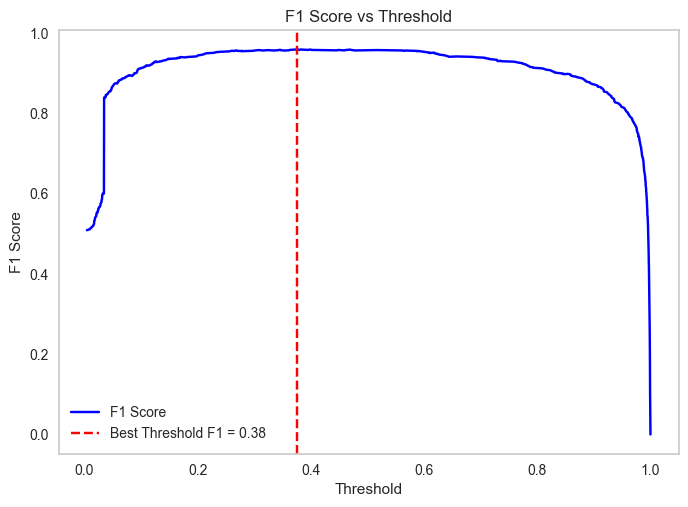

In [15]:
thresholds = np.append(thresholds, 1.0)
plt.plot(thresholds, f1_scores, label='F1 Score', color='blue')
plt.axvline(x=best_threshold_f1, color='red', linestyle='--', label=f'Best Threshold F1 = {best_threshold_f1:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid()
plt.show()

In [16]:
# Train on full data
best_params = study.best_params
final_model = lgb.LGBMClassifier(**best_params, random_state=42)

X, y = sms_spam_df['Message'], sms_spam_df['Label']

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)

# Train on full training set (train + validation)
X_full_train_ml, y_full_train, vectorizer = tfidf_vectorizer(X_train, y_train)
X_test_ml = vectorizer.transform(X_test)

final_model.fit(X_full_train_ml, y_full_train)

# Evaluate on test set
y_pred_final = final_model.predict(X_test_ml)
y_pred_proba_final = final_model.predict_proba(X_test_ml)[:, 1]

calculate_metrics(y_test, y_pred_final, y_pred_proba_final)

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.777841917498427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.777841917498427
[LightGBM] [Warning] bagging_fraction is set=0.6182009164692555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6182009164692555
[LightGBM] [Warning] lambda_l2 is set=0.45964636537866144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.45964636537866144
[LightGBM] [Warning] lambda_l1 is set=0.13453128828541994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13453128828541994


,Accuracy,Precision,Recall (Sensitivity),Specificity (TNR),ROC_AUC_Score,PR_AUC_Score,F1_Score,F2_Score,Confusion_Matrix
0,0.971473,0.987076,0.928571,0.993701,0.994728,0.993586,0.95693,0.939711,"[1262, 8]"
1,0.971473,0.987076,0.928571,0.993701,0.994728,0.993586,0.95693,0.939711,"[47, 611]"


In [17]:
best_threshold_for_f1 = 0.45214381351932115 
custom_preds = (y_pred_proba_final >= best_threshold_for_f1).astype(int)
calculate_metrics(y_test, custom_preds, y_pred_proba_final)

,Accuracy,Precision,Recall (Sensitivity),Specificity (TNR),ROC_AUC_Score,PR_AUC_Score,F1_Score,F2_Score,Confusion_Matrix
0,0.970436,0.976228,0.93617,0.988189,0.994728,0.993586,0.95578,0.943917,"[1255, 15]"
1,0.970436,0.976228,0.93617,0.988189,0.994728,0.993586,0.95578,0.943917,"[42, 616]"


# Using Pretrained Deep Learning Models from Hugging Face (Ran on Google Colab - T4)

In [24]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
sms_spam_df = pd.read_csv("sms_spam_df.csv")

# Define model names for each language
model_names = {
    "tr": "BaranKanat/BerTurk-SpamSMS",
    "en": "mrm8488/bert-tiny-finetuned-sms-spam-detection",
    "id": "kasyfilalbar/indo-spam-chatbot"
}

# Function to classify SMS messages and probabilities
def get_predictions_and_probs(model_name, messages, batch_size=16):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

    all_preds = []
    all_probs = []

    for i in range(0, len(messages), batch_size):
        batch_texts = messages[i:i+batch_size]
        inputs = tokenizer(batch_texts.tolist(), padding="longest", truncation=True, return_tensors="pt", max_length=128).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        # Add softmax to generate probs
        probs = F.softmax(outputs.logits, dim=1).cpu().numpy()
        predictions = probs.argmax(axis=1)

        all_preds.extend(predictions)
        all_probs.extend(probs[:, 1])

    return all_preds, all_probs

# Store metrics
all_metrics = {}
all_preds_combined = []
all_probs_combined = []
all_labels_combined = []

# Process each language separately
for lang, model_name in model_names.items():
    lang_df = sms_spam_df[sms_spam_df["Language"] == lang].copy()

    print(f"\n Predicting for {model_name} ({lang})...\n")

    preds, spam_probs = get_predictions_and_probs(model_name, lang_df["Message"])

    lang_df["Predicted_Label"] = preds
    lang_df["Spam_Probability"] = spam_probs
    all_preds_combined.extend(preds)
    all_probs_combined.extend(spam_probs)
    all_labels_combined.extend(lang_df["Label"].tolist())

    # Calculate metrics for the language
    lang_metrics = calculate_metrics(lang_df["Label"], preds, spam_probs)
    all_metrics[f"Metrics_{lang}"] = lang_metrics

# Overall metrics
overall_metrics = calculate_metrics(all_labels_combined, all_preds_combined, all_probs_combined)
all_metrics["Overall_Metrics"] = overall_metrics

sms_spam_df["Predicted_Label"] = all_preds_combined
sms_spam_df["Spam_Probability"] = all_probs_combined

# Display metrics
for key, value in all_metrics.items():
    print(f"\n==== {key} ====\n")
    display(value)


Using device: cuda

 Predicting for BaranKanat/BerTurk-SpamSMS (tr)...


 Predicting for mrm8488/bert-tiny-finetuned-sms-spam-detection (en)...


 Predicting for kasyfilalbar/indo-spam-chatbot (id)...



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


==== Metrics_tr ====



,Accuracy,Precision,Recall (Sensitivity),Specificity (TNR),ROC_AUC_Score,PR_AUC_Score,F1_Score,F2_Score,Confusion_Matrix
0,0.99975,1.0,0.999534,1.0,0.999972,0.999977,0.999767,0.999628,"[1857, 0]"
1,0.99975,1.0,0.999534,1.0,0.999972,0.999977,0.999767,0.999628,"[1, 2147]"



==== Metrics_en ====



,Accuracy,Precision,Recall (Sensitivity),Specificity (TNR),ROC_AUC_Score,PR_AUC_Score,F1_Score,F2_Score,Confusion_Matrix
0,0.982419,0.956973,0.922747,0.99279,0.992574,0.977302,0.939548,0.929395,"[3993, 29]"
1,0.982419,0.956973,0.922747,0.99279,0.992574,0.977302,0.939548,0.929395,"[54, 645]"



==== Metrics_id ====



,Accuracy,Precision,Recall (Sensitivity),Specificity (TNR),ROC_AUC_Score,PR_AUC_Score,F1_Score,F2_Score,Confusion_Matrix
0,0.784228,0.901961,0.623025,0.93617,0.843576,0.865975,0.736983,0.6641,"[440, 30]"
1,0.784228,0.901961,0.623025,0.93617,0.843576,0.865975,0.736983,0.6641,"[167, 276]"



==== Overall_Metrics ====



,Accuracy,Precision,Recall (Sensitivity),Specificity (TNR),ROC_AUC_Score,PR_AUC_Score,F1_Score,F2_Score,Confusion_Matrix
0,0.970848,0.981132,0.932523,0.990707,0.980161,0.981229,0.95621,0.941855,"[6290, 59]"
1,0.970848,0.981132,0.932523,0.990707,0.980161,0.981229,0.95621,0.941855,"[222, 3068]"
